<a href="https://colab.research.google.com/github/SharmaSanskar/fast-ai/blob/main/first_neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A low level understanding of neural nets by making a model which predicts if a number is a 3 or a 7.**

Steps involved in making the neural net:
1. Initialize the weights.
2. For each image, use these weights to predict whether it appears to be a 3 or a 7.
3. Based on these predictions, calculate how good the model is (its loss).
4. Calculate the gradient, which measures for each weight, how changing that weight would change the loss.
5. Step (that is, change) all the weights based on that calculation.
6. Go back to the step 2, and repeat the process.
7. Iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer).

# Imports

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.5MB/s 
     |████████████████████████████████| 1.2MB 54.1MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 194kB 51.6MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *

# Loading the data

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
path

Path('/root/.fastai/data/mnist_sample')

In [5]:
Path.BASE_PATH = path

In [6]:
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [8]:
img_3 = Image.open(threes[1])
img_3

In [9]:
tensor_3 = tensor(img_3)
df = pd.DataFrame(tensor_3)
df.style.set_properties().background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


## Creating training data

List containing 28x28 tensors of images

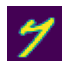

In [10]:
three_tnsrs = [tensor(Image.open(i)) for i in threes]
seven_tnsrs = [tensor(Image.open(i)) for i in sevens]
show_image(seven_tnsrs[1])

In [11]:
len(three_tnsrs), len(seven_tnsrs)

(6131, 6265)

In [12]:
print("Shape: ", three_tnsrs[1].shape)
print("Dimensions: ", three_tnsrs[1].ndim)

Shape:  torch.Size([28, 28])
Dimensions:  2


Stacking each image tensor in the list to form rank 3 tensor

In [13]:
stacked_sevens = torch.stack(seven_tnsrs).float()/255
stacked_threes = torch.stack(three_tnsrs).float()/255

In [14]:
print("Shape: ", stacked_threes.shape)
print("Dimensions: ", stacked_threes.ndim)

Shape:  torch.Size([6131, 28, 28])
Dimensions:  3


## Creating validation data

Similar process as done for the training data

In [15]:
valid_threes = [tensor(Image.open(i)) for i in (path/'valid'/'3').ls()]
valid_threes = torch.stack(valid_threes).float()/255
valid_sevens = [tensor(Image.open(i)) for i in (path/'valid'/'7').ls()]
valid_sevens = torch.stack(valid_sevens).float()/255
valid_threes.shape, valid_sevens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

# Making the Datasets

## Training Dataset

Each row is one example image reshaped in 1D of 784 values

In [16]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
pd.DataFrame(train_x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.164706,0.462745,0.858824,0.650980,0.462745,0.462745,0.023529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.403922,0.949020,0.996078,0.996078,0.996078,0.996078,0.996078,0.258824,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.070588,0.909804,0.996078,0.996078,0.996078,0.996078,0.996078,0.933333,0.274510,0.000000,0.000000,0.0,0.0,0.0,0.0

In [17]:
train_y = tensor([1]*len(stacked_threes) + [0]*len(stacked_sevens)).unsqueeze(1) # unsqueeze adds an addditional dimension of size one
pd.DataFrame(train_y)

,0
0,1
1,1
2,1
3,1
4,1
...,...
12391,0
12392,0
12393,0
12394,0


In [18]:
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

## Testing Dataset

In [19]:
valid_x = torch.cat([valid_threes, valid_sevens]).view(-1, 28*28)
pd.DataFrame(valid_x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.462745,0.898039,1.000000,0.596078,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.196078,0.643137,0.992157,0.992157,0.992157,0.925490,0.164706,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [20]:
valid_y = tensor([1]*len(valid_threes) + [0]*len(valid_sevens)).unsqueeze(1)
pd.DataFrame(valid_y)

,0
0,1
1,1
2,1
3,1
4,1
...,...
2033,0
2034,0
2035,0
2036,0


## Complete Dataset

In [21]:
train_dset = list(zip(train_x, train_y))
x, y = train_dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [22]:
valid_dset = list(zip(valid_x, valid_y))
x, y = valid_dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

# Create DataLoader from Dataset

A DataLoader can take any Python collection and turn it into an iterator over many batches.

In [23]:
train_dl = DataLoader(train_dset, batch_size=256)
xb, yb = first(train_dl) # First batch of size 256
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [24]:
valid_dl = DataLoader(valid_dset, batch_size=256)

# Initialize Parameters

In [25]:
def init_params(size, std=1.0):
  return (torch.randn(size)*std).requires_grad_()

In [26]:
weights = init_params((28*28, 1))

In [27]:
bias = init_params(1)

In [28]:
weights.ndim, bias.ndim

(2, 1)

# Loss Function

In [29]:
def simple_loss(preds, targets):
  return torch.where(targets==1, 1-preds, preds).mean()

In [30]:
targets = tensor([1, 0, 1])
preds = tensor([0.9, 0.2, 0.4])
torch.where(targets==1, 1-preds, preds)

tensor([0.1000, 0.2000, 0.6000])

In [31]:
simple_loss(preds, targets)

tensor(0.3000)

## Sigmoid

Our loss function requires prediction values between 0 and 1.
Therefore we can use the **Sigmoid** function

/usr/local/lib/python3.7/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:25.)
  x = torch.linspace(min,max)


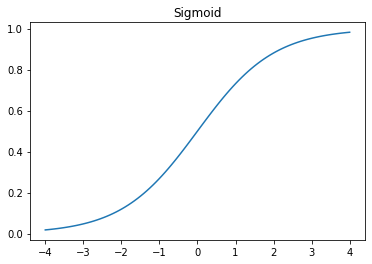

In [32]:
plot_function(torch.sigmoid, title="Sigmoid", min=-4, max=4)

In [33]:
tensor([14, 19, 22]).sigmoid()

tensor([1.0000, 1.0000, 1.0000])

In [34]:
def simple_loss(preds, targets):
  preds = preds.sigmoid()
  return torch.where(targets==1, 1-preds, preds).mean()

# Linear Function

A simple function of form **y = wx + b**. Can be calculated using matrix multiplication.   
In Python, matrix multiplication is represented with the **@** operator.


In [35]:
def simple_linear(xb):
  return xb@weights + bias

# Calculating Gradient

In [36]:
batch = train_x[:4] # First 4 training examples
batch.shape

torch.Size([4, 784])

In [37]:
preds = simple_linear(batch)
preds

tensor([[  1.1245],
        [ -0.6243],
        [ -1.7694],
        [-12.7221]], grad_fn=<AddBackward0>)

In [38]:
loss = simple_loss(preds, train_y[:4])
loss

tensor(0.6877, grad_fn=<MeanBackward0>)

In [39]:
loss.backward()

In [40]:
print("Shapes: ", weights.grad.shape, bias.grad.shape)
print("Gradients: ", weights.grad.mean(), bias.grad)

Shapes:  torch.Size([784, 1]) torch.Size([1])
Gradients:  tensor(-0.0192) tensor([-0.1342])


In [41]:
def calc_gradient(xb, yb, model):
  preds = model(xb)
  loss = simple_loss(preds, yb)
  loss.backward()

In [42]:
calc_gradient(batch, train_y[:4], simple_linear)
weights.grad.mean(), bias.grad

(tensor(-0.0383), tensor([-0.2683]))

In [43]:
calc_gradient(batch, train_y[:4], simple_linear)
weights.grad.mean(), bias.grad

(tensor(-0.0575), tensor([-0.4025]))

The gradients have changed! The reason for this is that loss.backward actually adds the gradients of loss to any gradients that are currently stored. So, we have to set the current gradients to 0 first.

In [44]:
weights.grad.zero_()
bias.grad.zero_();

# Training and Validating epoch

## Training epoch

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the data attribute of a tensor then PyTorch will not take the gradient of that step.

In [45]:
def train_epoch(model, lr, params):
  for xb, yb in train_dl:
    calc_gradient(xb, yb, model)  # Calculating gradients
    for p in params:
      p.data -= p.grad * lr # Step (i.e. Update the params)
      p.grad.zero_() # Reset the current gradients to 0

## Checking accuracy

In [46]:
def batch_accuracy(preds, yb):
  preds = preds.sigmoid()
  correct = (preds > 0.5) == yb
  return correct.float().mean()

In [47]:
batch_accuracy(simple_linear(batch), train_y[:4])

tensor(0.2500)

## Validating epoch

Checking the accuracy over each batch in the validation set.

In [48]:
def valid_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

In [49]:
valid_epoch(simple_linear)

0.5157

## Training and Validating multiple epochs

In [50]:
lr = 1
params = weights, bias
for i in range(20):
  train_epoch(simple_linear, lr, params)
  print(valid_epoch(simple_linear), end = " ")

0.6257 0.7894 0.8978 0.9272 0.9399 0.9486 0.955 0.9614 0.9643 0.9658 0.9668 0.9687 0.9687 0.9712 0.9726 0.9736 0.9746 0.9751 0.9751 0.9751 

Our accuracy increases with each epoch :)

# Refactoring

Replace our **simple_linear** function with PyTorch's **nn.Linear** module.    
**nn.Linear** does the same thing as our init_params and linear together. It contains both the weights and biases in a single class.

In [51]:
linear_model = nn.Linear(28*28, 1)

In [52]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

## Creating Basic Optimizer

A basic optimizer which takes a step (i.e. update the params) and then resets the current gradients.

In [53]:
class BasicOptimizer:
  def __init__(self, params, lr):
    self.params = list(params)
    self.lr = lr

  def step(self, *args, **kwargs):
    for p in self.params:
      p.data -= p.grad.data * self.lr 

  def zero_grad(self, *args, **kwargs):
    for p in self.params:
      p.grad = None

In [54]:
opt = BasicOptimizer(linear_model.parameters(), lr)

Modifying the train_epoch function to use the optimizer.

In [55]:
def train_epoch(model):
  for xb, yb in train_dl:
    calc_gradient(xb, yb, model)  # Calculating gradients
    opt.step()
    opt.zero_grad()

## Creating Training loop

In [56]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(f"Epoch {i+1}: {valid_epoch(model)}")

In [57]:
train_model(linear_model, 10)

Epoch 1: 0.4932
Epoch 2: 0.832
Epoch 3: 0.8452
Epoch 4: 0.9126
Epoch 5: 0.9341
Epoch 6: 0.9473
Epoch 7: 0.9561
Epoch 8: 0.9634
Epoch 9: 0.9663
Epoch 10: 0.9678


Replace our **BasicOptimizer** class with **SGD** class provided by fastai.

In [58]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 10)

Epoch 1: 0.4932
Epoch 2: 0.7734
Epoch 3: 0.8569
Epoch 4: 0.918
Epoch 5: 0.9365
Epoch 6: 0.9502
Epoch 7: 0.9561
Epoch 8: 0.9634
Epoch 9: 0.9658
Epoch 10: 0.9673


Replace our **train_model** with **Learner.fit** provided by fastai.   

First we need to create a **DataLoaders** containing both train and valid dataloaders.

In [59]:
dls = DataLoaders(train_dl, valid_dl)

Create a **Learner** by passing all the elements we've created so far.

In [60]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=simple_loss, metrics=batch_accuracy)

In [61]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636993,0.503495,0.495584,00:00
1,0.523182,0.181787,0.851325,00:00
2,0.191852,0.184785,0.833170,00:00
3,0.084018,0.107211,0.911678,00:00
4,0.044313,0.077999,0.932777,00:00
5,0.028816,0.062425,0.947988,00:00
6,0.022445,0.052751,0.955348,00:00
7,0.019615,0.046326,0.962218,00:00
8,0.018187,0.041822,0.965653,00:00
9,0.017336,0.038509,0.966634,00:00


# Adding Non-Linearity

The composition of two or more linear functions is another linear function.   
We need to add something non-linear between two linear classifiers—this is what gives us a neural network.

Here is the entire definition of a basic neural network:

In [62]:
def simple_net(xb):
  res = xb@w1 + b1
  res = res.max(tensor(0.0))
  res = res@w2 + b2
  return res

The first and third are known as **linear layers**, and the second line of code is a non-linearity, also known as an **activation function**.

In [63]:
w1 = init_params((28*28, 30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)

The 30 output activations of w1 must match the 30 input activations of w2.

The little activation function res.max(tensor(0.0)) is called a Rectified Linear Unit, also known as **ReLU**.

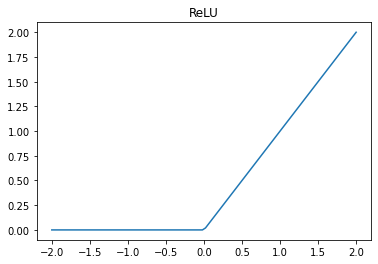

In [64]:
plot_function(F.relu, title="ReLU")

Replace our **simple_net** with **nn.Sequential** provided by PyTorch which creates a module that will call each of the listed layers or functions in turn.

In [65]:
simple_neural_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [66]:
learn = Learner(dls, simple_neural_net, opt_func=SGD, loss_func=simple_loss, metrics=batch_accuracy)

As this is a deeper model, we'll use a lower learning rate and a few more epochs.

In [67]:
learn.fit(40, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.338214,0.414769,0.504416,00:00
1,0.156209,0.235800,0.792934,00:00
2,0.084974,0.116157,0.912659,00:00
3,0.054919,0.077318,0.943081,00:00
4,0.041156,0.060012,0.957311,00:00
5,0.034219,0.050473,0.963690,00:00
6,0.030290,0.044549,0.966634,00:00
7,0.027769,0.040522,0.967615,00:00
8,0.025969,0.037600,0.969578,00:00
9,0.024583,0.035369,0.971050,00:00


The training process is recorded in **learn.recorder**, with the table of output stored in the **values** attribute, so we can view the final accuracy.

In [68]:
print("Final Accuracy: ", learn.recorder.values[-1][2])

Final Accuracy:  0.983316957950592


At this point we have something that is rather magical:
1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters.
2. A way to find the best set of parameters for any function (stochastic gradient descent).

# Using ResNet

Here's what happens when we train an 18-layer ResNet model to solve the same problem.

In [69]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, lr_max=0.1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,accuracy,time
0,0.103698,0.005229,0.998528,00:14


We get nearly 100% accuracy in just one epoch!!

**Now we know the foundations of how Neural Networks like the one above works.**